###### You are very welcome to use this code. For this, clearly acknowledge
###### the source of this code, and cite our papers described in the readme file.

###### Copyright (c) Roi Ronen. The python code is available for
###### non-commercial use and exploration.  For commercial use contact the
###### authors. The authors are not liable for any damages or loss that might be
###### caused by use or connection to this code.
###### All rights reserved.

###### This source code is licensed under the GPL-3.0 license found in the
###### LICENSE file in the root directory of this source tree.
---
# ProbCT uncertainty propagation to downstream task: Precipitation forecast
---
#### This notebook demonstrates the necessity of ProbCT uncertainty estimation on downstream forecast task using synthetic data.

In [1]:
import os, time
import warnings
warnings.filterwarnings('ignore')
import hydra
from hydra import compose, initialize
import numpy as np
from omegaconf import OmegaConf
from omegaconf import DictConfig
from dataloader.dataset import get_cloud_datasets, trivial_collate
from ProbCT.CTnetV2 import *
from ProbCT.util.discritize import get_pred_and_conf_from_discrete
from scene.cameras import AirMSPICameras
from scene.volumes import Volumes
from metrics.test_errors import *
import scipy.io as sio
from renderer.shdom_renderer import DiffRendererSHDOM_AirMSPI
import matplotlib.pyplot as plt
CONFIG_DIR = os.path.join("../", "configs")
hydra.core.global_hydra.GlobalHydra.instance().clear()

In [2]:
# Load ProbCT model
MODEL_ID_DIR = os.path.join("../", "models", "Test_BOMEX500", "Trained_BOMEX500")
MODEL_OOD_DIR = os.path.join("../", "models", "Test_BOMEX500", "Trained_CASS600")

def load_model(MODEL_DIR):
    with initialize(version_base='1.1', config_path=CONFIG_DIR, job_name="test_app"):
            cfg = compose(config_name="test")

    # Set the relevant seeds for reproducibility
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    
    resume_cfg_path = os.path.join(MODEL_DIR.split('/checkpoints')[0],'.hydra/config.yaml')
    net_cfg = OmegaConf.load(resume_cfg_path)
    cfg = OmegaConf.merge(net_cfg,cfg)
    cfg.checkpoint_resume_path = os.path.join(MODEL_DIR,"model.pth")
    
    # Initialize ProbCT model
    model = CTnetV2(cfg=cfg, n_cam=cfg.data.n_cam)

    # Load model
    print(f"Resuming from checkpoint {cfg.checkpoint_resume_path}.")
    loaded_data = torch.load(cfg.checkpoint_resume_path, map_location='cpu')
    model.load_state_dict(loaded_data["model"])
    # Set the model to eval mode.
    if cfg.mode == 'eval':
        model.eval().float()
    else:
        model.float()
    return model, cfg

model_id, cfg_id = load_model(MODEL_ID_DIR)
model_ood, cfg_ood = load_model(MODEL_OOD_DIR)

# Device on which to run
if torch.cuda.is_available() and cfg_id.debug == False:
    n_device = torch.cuda.device_count()
    cfg_id.gpu = 0 if n_device==1 else cfg_id.gpu
    device = f"cuda:{cfg_id.gpu}"
else:
    warnings.warn(
        "Please note that although executing on CPU is supported,"
        + "the training is unlikely to finish in reasonable time."
    )
    device = "cpu"


Using torchvision resnet50_fpn encoder
Resuming from checkpoint ../models/Test_BOMEX500/Trained_BOMEX500/model.pth.
Using torchvision resnet50_fpn encoder
Resuming from checkpoint ../models/Test_BOMEX500/Trained_CASS600/model.pth.


In [3]:
# Load inference data
DATA_DIR = os.path.join("../", "data")
cfg_id.data.dataset_name = 'BOMEX_5000CCN_new_10cameras_20m'
_, val_dataset = get_cloud_datasets(cfg=cfg_id, data_root=DATA_DIR)
cfg_id.ct_net.conf_type = 'entropy'
cfg_id.ct_net.decoder_batchify = True
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    num_workers=4,
    collate_fn=trivial_collate,
)

val_image, extinction, grid, image_sizes, projection_matrix, camera_center, masks, _ = next(iter(val_dataloader))
val_image = torch.tensor(np.array(val_image), device=device).float()    
val_volume = Volumes(torch.unsqueeze(torch.tensor(np.array(extinction), device=device).float(), 1), grid)
val_camera = PerspectiveCameras(image_size=image_sizes, P=torch.tensor(projection_matrix, device=device).float(),
                                    camera_center=torch.tensor(camera_center, device=device).float(), device=device)
n_points_mask =  np.array(masks).sum()
gt_vol = val_volume.extinctions[0].squeeze()


Loading dataset BOMEX_5000CCN_new_10cameras_20m, image size=[116, 116] ...


ID inference: relative_error = 0.3977545201778412, relative_mass_error = 0.025179298594594002,  L2 = 0.15308523178100586, Npoints = 5302
OOD inference: relative_error = 0.7411357760429382, relative_mass_error = -0.08302612602710724,  L2 = 0.41282880306243896, Npoints = 5302


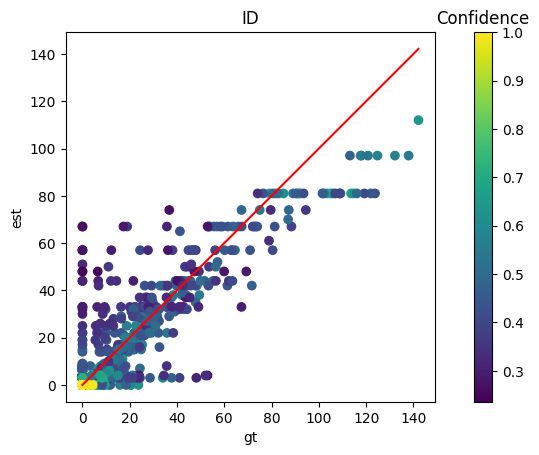

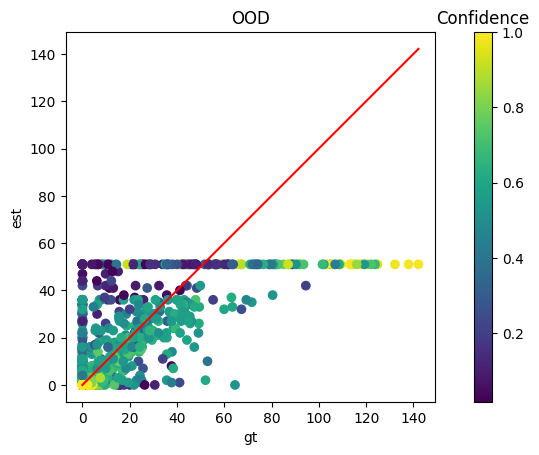

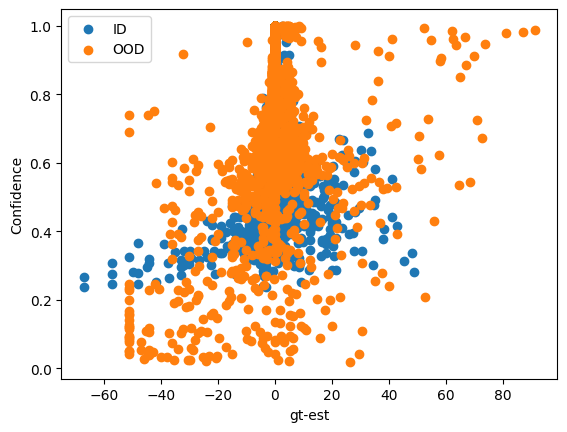

In [4]:
def probct_inference(model, val_image, val_volume, val_camera, masks=masks, cfg=cfg_id):
    
    if model.val_mask_type == 'gt_mask':
        masks = val_volume.extinctions > 0 #val_volume._ext_thr
    else:
        masks = [torch.tensor(mask) if mask is not None else torch.ones(*extinction[0].shape,device=device, dtype=bool) for mask in masks]

    with torch.no_grad():
        est_vols = torch.zeros(val_volume.extinctions.numel(), device=val_volume.device).reshape(
            val_volume.extinctions.shape[0], -1)
        n_points_mask = torch.sum(torch.stack(masks)*1.0) if isinstance(masks, list) else masks.sum()
        conf_vol = torch.ones_like(est_vols[0]) * torch.nan

        # don't make inference on empty/small clouds
        if n_points_mask > cfg_id.min_mask_points:
            net_start_time = time.time()

            val_out = model(
                val_camera,
                val_image,
                val_volume,
                masks
            )
            if val_out["output"][0].shape[-1]>1:
                val_out["output"], val_out["output_conf"], probs = get_pred_and_conf_from_discrete(val_out["output"],
                                                                                            cfg_id.cross_entropy.min,
                                                                                            cfg_id.cross_entropy.max,
                                                                                            cfg_id.cross_entropy.bins,
                                                                                            pred_type=cfg_id.ct_net.pred_type,
                                                                                            conf_type=cfg_id.ct_net.conf_type)
            for est_vol, out_vol, m in zip(est_vols, val_out["output"], val_out['query_indices']):
                est_vol[m] = out_vol.reshape(-1)
                conf_vol = torch.ones_like(est_vol) * torch.nan
                prob_vol = torch.ones(est_vol.numel(), probs[0].shape[-1],
                                      device=est_vol.device) * torch.nan
                conf_vol[m] = val_out["output_conf"][0]
                prob_vol[m] = probs[0]
            time_net = time.time() - net_start_time
        gt_vol = val_volume.extinctions[0].squeeze()
        est_vols = est_vols.squeeze().reshape(gt_vol.shape)
        if val_out["output_conf"] is not None:
            conf_vol = conf_vol.squeeze().reshape(gt_vol.shape)
            prob_vol = prob_vol.reshape(*gt_vol.shape,-1)
        else:
            conf_vol = torch.empty(1)
            prob_vol = torch.empty(1)
        masks[0] = masks[0].squeeze().reshape(gt_vol.shape)
        return est_vols, conf_vol, prob_vol


est_vol_ID, conf_vol_ID, prob_vol_ID = probct_inference(model_id.to(device), val_image, val_volume, val_camera)
print(f'ID inference: relative_error = {relative_error(ext_est=est_vol_ID,ext_gt=gt_vol)}, relative_mass_error = {relative_mass_error(ext_est=est_vol_ID,ext_gt=gt_vol)},  L2 = {relative_squared_error(ext_est=est_vol_ID,ext_gt=gt_vol)}, Npoints = {n_points_mask}')

est_vol_OOD, conf_vol_OOD, prob_vol_OOD = probct_inference(model_ood.to(device), val_image, val_volume, val_camera)
print(f'OOD inference: relative_error = {relative_error(ext_est=est_vol_OOD,ext_gt=gt_vol)}, relative_mass_error = {relative_mass_error(ext_est=est_vol_OOD,ext_gt=gt_vol)},  L2 = {relative_squared_error(ext_est=est_vol_OOD,ext_gt=gt_vol)}, Npoints = {n_points_mask}')



mask = masks[0]
gt_vol = gt_vol.cpu().numpy()
est_vol_ID = est_vol_ID.cpu().numpy()
conf_vol_ID = conf_vol_ID.cpu().numpy()
est_vol_OOD = est_vol_OOD.cpu().numpy()
conf_vol_OOD = conf_vol_OOD.cpu().numpy()

plt.scatter(gt_vol[mask], est_vol_ID[mask],c=conf_vol_ID[mask])
clb =plt.colorbar()
clb.ax.set_title('Confidence')
plt.plot([0,gt_vol[mask].max()],[0,gt_vol[mask].max()],'r')
plt.xlabel('gt')
plt.ylabel('est')
plt.axis('square')
plt.title('ID')
plt.show()

plt.scatter(gt_vol[mask], est_vol_OOD[mask],c=conf_vol_OOD[mask])
clb =plt.colorbar()
clb.ax.set_title('Confidence')
plt.plot([0,gt_vol[mask].max()],[0,gt_vol[mask].max()],'r')
plt.xlabel('gt')
plt.ylabel('est')
plt.axis('square')
plt.title('OOD')
plt.show()

plt.scatter(gt_vol[mask] - est_vol_ID[mask], conf_vol_ID[mask])
plt.scatter(gt_vol[mask] - est_vol_OOD[mask], conf_vol_OOD[mask])
plt.legend(['ID','OOD'])
plt.xlabel('gt-est')
plt.ylabel('Confidence')
plt.show()

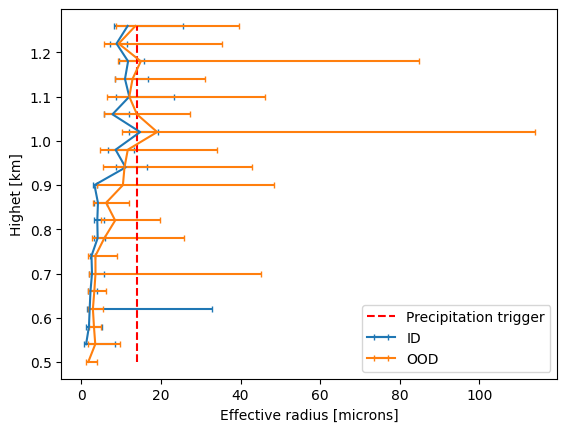

In [8]:
# Show the mean droplet effective radius estimated profiles under the adiabatic approximation
lwc_ad = sio.loadmat('files/lwc_ad.mat')['lwc_ad'] * 1e5 #units
#LWC_ad is in 10m steps from cloud base, sample to recovery vertical resolution of 40m
lwc_z=np.arange(1,lwc_ad.size,4)
lwc_ad=lwc_ad[lwc_z]

def get_eff_radius(est_vol, ext_std, lwc_ad, thr=5): #implementation should include dropping cloud outer shell of 2 voxel thickness by morphological operations
    cloud_base = (est_vol>0).sum((0,1))
    cloud_base = (cloud_base!=0).argmax(axis=0)
    cloud_base = cloud_base
    ext = est_vol
    ext_p_std = ext + ext_std
    ext_m_std = ext - ext_std
    
    ext_m_std[ext_m_std<0]=0
    ext[:,:,:cloud_base]=0
    ext_p_std[:,:,:cloud_base]=0
    ext_m_std[:,:,:cloud_base]=0
    
    lwc_ad = lwc_ad[:(ext.shape[-1]-cloud_base)].ravel()[None,None]
    ext = ext[:,:,cloud_base:(lwc_ad.shape[-1]+cloud_base)]
    ext_p_std = ext_p_std[:,:,cloud_base:(lwc_ad.shape[-1]+cloud_base)]
    ext_m_std = ext_m_std[:,:,cloud_base:(lwc_ad.shape[-1]+cloud_base)]
    
    ext[ext<thr] = np.nan
    ext_p_std[ext<thr] = np.nan
    ext_m_std[ext<thr] = np.nan
    
    Q = 2
    r_eff = 3/4 * Q * lwc_ad / ext
    r_eff[np.isinf(r_eff)]=np.nan
    avg_r_eff = np.nanmean(r_eff,axis=(0,1))
    avg_r_eff[np.isnan(avg_r_eff)]=0
    
    r_eff_p = 3/4 * Q * lwc_ad / ext_p_std
    r_eff_p[np.isinf(r_eff_p)]=np.nan
    avg_r_eff_p = np.nanmean(r_eff_p,axis=(0,1))
    avg_r_eff_p[np.isnan(avg_r_eff_p)]=0

    r_eff_m = 3/4 * Q * lwc_ad / ext_m_std
    r_eff_m[np.isinf(r_eff_m)]=np.nan
    avg_r_eff_m = np.nanmean(r_eff_m,axis=(0,1))
    avg_r_eff_m[np.isnan(avg_r_eff_m)]=0
    
    z = np.arange(20, 20+(est_vol.shape[-1])*40 , 40, dtype=float) / 1000
    z = z[cloud_base:(cloud_base+avg_r_eff.shape[-1])]

    return avg_r_eff, avg_r_eff_p, avg_r_eff_m, z


def get_std_ext(prob, min=cfg_id.cross_entropy.min, max=cfg_id.cross_entropy.max, bins=cfg_id.cross_entropy.bins):
    prob = prob.cpu().numpy()
    bin_values = np.linspace(min, max, bins)
    weighted_bins = prob * bin_values
    avg = weighted_bins.sum(-1)
    std = ((prob*(bin_values[None,None,None]- avg[...,None])**2).sum(-1) )**0.5
    return std

ext_std_ID = get_std_ext(prob_vol_ID)
ext_std_ID[~mask]=0
avg_r_eff, avg_r_eff_p, avg_r_eff_m, z = get_eff_radius(est_vol_ID, ext_std_ID, lwc_ad)
err = np.array(list(zip(avg_r_eff-avg_r_eff_p, avg_r_eff_m-avg_r_eff))).T
err[err<0]=0
plt.errorbar(avg_r_eff,z,xerr=err, capsize=2)

ext_std_OOD = get_std_ext(prob_vol_OOD)
ext_std_OOD[~mask]=0
avg_r_eff, avg_r_eff_p, avg_r_eff_m, z = get_eff_radius(est_vol_OOD, ext_std_OOD, lwc_ad)
err = np.array(list(zip(avg_r_eff-avg_r_eff_p, avg_r_eff_m-avg_r_eff))).T
err[err<0]=0
plt.errorbar(avg_r_eff,z,xerr=err, capsize=2)

plt.plot([14, 14],[z.min(), z.max()], '--r')
plt.legend(['Precipitation trigger', 'ID','OOD'])
plt.ylabel('Highet [km]')
plt.xlabel('Effective radius [microns]')
plt.show()